In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from PIL import Image
import os
from sklearn.utils import shuffle
import cv2
import glob
import imageio
import PIL
from tensorflow.keras import layers
import time
from IPython import display
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import shuffle

Using TensorFlow backend.


In [2]:
input_path="/kaggle/input/fulldata/fulldata/lee_full/"
input_land_path="/kaggle/input/fulldata/fulldata/lee_full_land/"
output_path="/kaggle/input/fulldata/fulldata/iu_full/"
output_land_path="/kaggle/input/fulldata/fulldata/iu_full_land/"



images_input = os.listdir(input_path)
images_input_land = os.listdir(input_land_path)
images_output = os.listdir(output_path)
images_output_land = os.listdir(output_land_path)
images_input.sort()
images_input_land.sort()
images_output.sort()
images_output_land.sort()


In [3]:
train_data_input=[]
for i in range(len(images_input)):
    img = cv2.imread(input_path+images_input[i])
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    train_data_input.append(img)   
        
train_data_input_land=[]
for i in range(len(images_input_land)):
    img = cv2.imread(input_land_path+images_input_land[i])
    img = cv2.resize(img,(64,64))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    train_data_input_land.append(img)    
    
train_data_output=[]
for i in range(len(images_output)):
    img = cv2.imread(output_path+images_output[i])
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    train_data_output.append(img)   
        
train_data_output_land=[]
for i in range(len(images_output_land)):
    img = cv2.imread(output_land_path+images_output_land[i])
    img = cv2.resize(img,(64,64))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    train_data_output_land.append(img)    


In [4]:
data_input = np.array(train_data_input)
data_input = data_input/255

data_input_land = np.array(train_data_input_land)
data_input_land= data_input_land/255

data_output = np.array(train_data_output)
data_output= data_output/255

data_output_land = np.array(train_data_output_land)
data_output_land= data_output_land/255

In [5]:
data_input = shuffle(data_input, random_state=12)
data_input_land = shuffle(data_input_land, random_state=12)
data_output = shuffle(data_output, random_state=12)
data_output_land = shuffle(data_output_land, random_state=12)

In [6]:
def umeyama( src, dst, estimate_scale ):

    num = src.shape[0]
    dim = src.shape[1]

    # Compute mean of src and dst.
    src_mean = src.mean(axis=0)
    dst_mean = dst.mean(axis=0)

    # Subtract mean from src and dst.
    src_demean = src - src_mean
    dst_demean = dst - dst_mean

    # Eq. (38).
    A = np.dot(dst_demean.T, src_demean) / num

    # Eq. (39).
    d = np.ones((dim,), dtype=np.double)
    if np.linalg.det(A) < 0:
        d[dim - 1] = -1

    T = np.eye(dim + 1, dtype=np.double)

    U, S, V = np.linalg.svd(A)

    # Eq. (40) and (43).
    rank = np.linalg.matrix_rank(A)
    if rank == 0:
        return np.nan * T
    elif rank == dim - 1:
        if np.linalg.det(U) * np.linalg.det(V) > 0:
            T[:dim, :dim] = np.dot(U, V)
        else:
            s = d[dim - 1]
            d[dim - 1] = -1
            T[:dim, :dim] = np.dot(U, np.dot(np.diag(d), V))
            d[dim - 1] = s
    else:
        T[:dim, :dim] = np.dot(U, np.dot(np.diag(d), V.T))

    if estimate_scale:
        # Eq. (41) and (42).
        scale = 1.0 / src_demean.var(axis=0).sum() * np.dot(S, d)
    else:
        scale = 1.0

    T[:dim, dim] = dst_mean - scale * np.dot(T[:dim, :dim], src_mean.T)
    T[:dim, :dim] *= scale

    return T

def random_warp( image ):
    assert image.shape == (64,64,3)
    #range_ = numpy.linspace( 128-80, 128+80, 5 )
    range_ = np.linspace( 32-30, 32+30, 5 )
    mapx = np.broadcast_to( range_, (5,5) )
    mapy = mapx.T

    mapx = mapx + np.random.normal( size=(5,5), scale=1 )
    mapy = mapy + np.random.normal( size=(5,5), scale=1 )

    interp_mapx = cv2.resize( mapx, (80,80) )[8:72,8:72].astype('float32')
    interp_mapy = cv2.resize( mapy, (80,80) )[8:72,8:72].astype('float32')

    warped_image = cv2.remap( image, interp_mapx, interp_mapy, cv2.INTER_LINEAR )

    src_points = np.stack( [ mapx.ravel(), mapy.ravel() ], axis=-1 )
    dst_points = np.mgrid[0:65:16,0:65:16].T.reshape(-1,2)
    mat = umeyama( src_points, dst_points, True )[0:2]

    target_image = cv2.warpAffine( image, mat, (64,64) )

    return warped_image, target_image

In [38]:
warp_data_input = []
for i in range(len(data_input)):
    warp_data_input.append(random_warp(data_input[i])[0])
warp_data_input = np.array(warp_data_input)

warp_data_output = []
for i in range(len(data_output)):
    warp_data_output.append(random_warp(data_output[i])[0])
warp_data_output = np.array(warp_data_output)

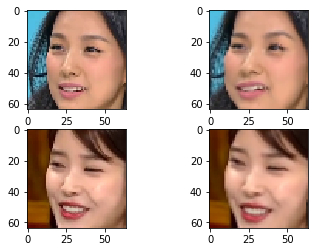

In [8]:
plt.subplot(2,2,1)
plt.imshow(data_input[115])
plt.subplot(2,2,2)
plt.imshow(warp_data_input[115])
plt.subplot(2,2,3)
plt.imshow(data_output[115])
plt.subplot(2,2,4)
plt.imshow(warp_data_output[115])

In [9]:
def encoder():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(48, (3, 3), activation='relu', padding='same' , input_shape=[64, 64, 3]))
    model.add(layers.Conv2D(48, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(96, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(192, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(32, (1, 1), activation='relu', padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(200))
    return model

def decoder():
    model = tf.keras.Sequential()
    dropout = 0.4 
    depth = 64 *4
    dim = 8
    model.add(layers.Dense(dim*dim*depth, input_dim=200))
    model.add(layers.BatchNormalization(momentum=0.9)) 
    model.add(layers.Activation('relu'))
    model.add(layers.Reshape((dim, dim, depth))) 
    model.add(layers.Dropout(dropout)) 
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2DTranspose(int(depth/2), 5, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2DTranspose(int(depth/4), 5, padding='same')) 
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.Activation('relu')) 
    model.add(layers.Conv2DTranspose(int(depth/8), 5, padding='same')) 
    model.add(layers.BatchNormalization(momentum=0.9)) 
    model.add(layers.Activation('relu'))
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2DTranspose(3, 5, padding='same'))
    model.add(layers.Activation('tanh'))
    return model              

def autoencoder(encoder , decoder):
    model = tf.keras.Sequential()
    model = tf.keras.models.clone_model(encoder)
    model.add(decoder)
    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

def build_adversarial_model(gen_model, dis_model):
    model = tf.keras.Sequential()
    model.add(gen_model)
    dis_model.trainable = False
    model.add(dis_model)
    return model

In [29]:
encode = encoder()
decode_input = decoder()
decode_output = decoder()
generator_input = autoencoder(encode,decode_input)
generator_output = autoencoder(encode,decode_output)
#generator_input.load_weights("/kaggle/input/fulldata/generator_best_input.h5")
generator_output.load_weights("/kaggle/input/fulldata/generator_best_output (16).h5")


In [40]:
generator_optimizer = tf.keras.optimizers.Adam(lr=0.002, beta_1=0.5)
generator_input.compile(loss='mse', optimizer=generator_optimizer)
generator_output.compile(loss='mse', optimizer=generator_optimizer)

In [46]:
generator_output.fit(warp_data_output[:8000], data_output[:8000],
                epochs=1000,
                batch_size=256,
                shuffle=True,
                validation_data=(warp_data_output[8000:], data_output[ 8000:]),
                verbose=2,
                callbacks=[ModelCheckpoint(filepath='generator_best_output.h5',
                save_weights_only=True, save_best_only=True, verbose=2)])
generator_input.fit(warp_data_input[:3500], data_input[:3500],
                epochs=500,
                batch_size=256,
                shuffle=True,
                validation_data=(warp_data_input[3500:], data_input[3500:]),
                verbose=2,
                callbacks=[ModelCheckpoint(filepath='generator_best_input.h5',
                save_weights_only=True, save_best_only=True, verbose=2)])


Train on 8000 samples, validate on 2151 samples
Epoch 1/3000

Epoch 00001: val_loss improved from inf to 0.00355, saving model to generator_best_output.h5
8000/8000 - 7s - loss: 0.0018 - val_loss: 0.0035
Epoch 2/3000

Epoch 00002: val_loss did not improve from 0.00355
8000/8000 - 5s - loss: 0.0018 - val_loss: 0.0051
Epoch 3/3000

Epoch 00003: val_loss did not improve from 0.00355
8000/8000 - 5s - loss: 0.0018 - val_loss: 0.0092
Epoch 4/3000

Epoch 00004: val_loss did not improve from 0.00355
8000/8000 - 5s - loss: 0.0018 - val_loss: 0.0058
Epoch 5/3000

Epoch 00005: val_loss did not improve from 0.00355
8000/8000 - 5s - loss: 0.0018 - val_loss: 0.0039
Epoch 6/3000

Epoch 00006: val_loss improved from 0.00355 to 0.00286, saving model to generator_best_output.h5
8000/8000 - 5s - loss: 0.0018 - val_loss: 0.0029
Epoch 7/3000

Epoch 00007: val_loss did not improve from 0.00286
8000/8000 - 5s - loss: 0.0018 - val_loss: 0.0034
Epoch 8/3000

Epoch 00008: val_loss did not improve from 0.00286
8

Epoch 71/3000

Epoch 00071: val_loss did not improve from 0.00258
8000/8000 - 5s - loss: 0.0012 - val_loss: 0.0038
Epoch 72/3000

Epoch 00072: val_loss did not improve from 0.00258
8000/8000 - 5s - loss: 0.0012 - val_loss: 0.0042
Epoch 73/3000

Epoch 00073: val_loss did not improve from 0.00258
8000/8000 - 5s - loss: 0.0012 - val_loss: 0.0036
Epoch 74/3000

Epoch 00074: val_loss did not improve from 0.00258
8000/8000 - 5s - loss: 0.0012 - val_loss: 0.0060
Epoch 75/3000

Epoch 00075: val_loss did not improve from 0.00258
8000/8000 - 5s - loss: 0.0012 - val_loss: 0.0031
Epoch 76/3000

Epoch 00076: val_loss did not improve from 0.00258
8000/8000 - 5s - loss: 0.0012 - val_loss: 0.0030
Epoch 77/3000

Epoch 00077: val_loss did not improve from 0.00258
8000/8000 - 5s - loss: 0.0012 - val_loss: 0.0026
Epoch 78/3000

Epoch 00078: val_loss did not improve from 0.00258
8000/8000 - 5s - loss: 0.0012 - val_loss: 0.0032
Epoch 79/3000

Epoch 00079: val_loss did not improve from 0.00258
8000/8000 - 5s

Epoch 141/3000

Epoch 00141: val_loss did not improve from 0.00201
8000/8000 - 5s - loss: 9.5848e-04 - val_loss: 0.0035
Epoch 142/3000

Epoch 00142: val_loss did not improve from 0.00201
8000/8000 - 5s - loss: 9.5214e-04 - val_loss: 0.0043
Epoch 143/3000

Epoch 00143: val_loss did not improve from 0.00201
8000/8000 - 5s - loss: 9.5606e-04 - val_loss: 0.0091
Epoch 144/3000

Epoch 00144: val_loss did not improve from 0.00201
8000/8000 - 5s - loss: 9.4885e-04 - val_loss: 0.0026
Epoch 145/3000

Epoch 00145: val_loss did not improve from 0.00201
8000/8000 - 5s - loss: 9.5432e-04 - val_loss: 0.0068
Epoch 146/3000

Epoch 00146: val_loss did not improve from 0.00201
8000/8000 - 5s - loss: 9.4196e-04 - val_loss: 0.0048
Epoch 147/3000

Epoch 00147: val_loss did not improve from 0.00201
8000/8000 - 5s - loss: 9.4635e-04 - val_loss: 0.0028
Epoch 148/3000

Epoch 00148: val_loss did not improve from 0.00201
8000/8000 - 5s - loss: 9.4476e-04 - val_loss: 0.0061
Epoch 149/3000

Epoch 00149: val_loss di

Epoch 209/3000

Epoch 00209: val_loss did not improve from 0.00191
8000/8000 - 5s - loss: 8.1450e-04 - val_loss: 0.0030
Epoch 210/3000

Epoch 00210: val_loss did not improve from 0.00191
8000/8000 - 5s - loss: 8.2530e-04 - val_loss: 0.0047
Epoch 211/3000

Epoch 00211: val_loss did not improve from 0.00191
8000/8000 - 5s - loss: 8.2035e-04 - val_loss: 0.0075
Epoch 212/3000

Epoch 00212: val_loss did not improve from 0.00191
8000/8000 - 5s - loss: 8.3985e-04 - val_loss: 0.0033
Epoch 213/3000

Epoch 00213: val_loss did not improve from 0.00191
8000/8000 - 5s - loss: 8.1023e-04 - val_loss: 0.0031
Epoch 214/3000

Epoch 00214: val_loss did not improve from 0.00191
8000/8000 - 5s - loss: 8.2618e-04 - val_loss: 0.0042
Epoch 215/3000

Epoch 00215: val_loss did not improve from 0.00191
8000/8000 - 5s - loss: 8.1894e-04 - val_loss: 0.0024
Epoch 216/3000

Epoch 00216: val_loss did not improve from 0.00191
8000/8000 - 5s - loss: 8.0596e-04 - val_loss: 0.0058
Epoch 217/3000

Epoch 00217: val_loss di

Epoch 278/3000

Epoch 00278: val_loss did not improve from 0.00191
8000/8000 - 5s - loss: 7.4495e-04 - val_loss: 0.0065
Epoch 279/3000

Epoch 00279: val_loss did not improve from 0.00191
8000/8000 - 5s - loss: 7.3399e-04 - val_loss: 0.0036
Epoch 280/3000

Epoch 00280: val_loss did not improve from 0.00191
8000/8000 - 5s - loss: 7.4200e-04 - val_loss: 0.0031
Epoch 281/3000

Epoch 00281: val_loss did not improve from 0.00191
8000/8000 - 5s - loss: 7.4265e-04 - val_loss: 0.0082
Epoch 282/3000

Epoch 00282: val_loss did not improve from 0.00191
8000/8000 - 5s - loss: 7.3247e-04 - val_loss: 0.0040
Epoch 283/3000

Epoch 00283: val_loss did not improve from 0.00191
8000/8000 - 5s - loss: 7.3736e-04 - val_loss: 0.0043
Epoch 284/3000

Epoch 00284: val_loss did not improve from 0.00191
8000/8000 - 5s - loss: 7.4263e-04 - val_loss: 0.0048
Epoch 285/3000

Epoch 00285: val_loss improved from 0.00191 to 0.00173, saving model to generator_best_output.h5
8000/8000 - 5s - loss: 7.4231e-04 - val_loss: 0

KeyboardInterrupt: 

In [47]:
#generator_input.load_weights("/kaggle/working/generator_best_input.h5")
generator_output.load_weights("/kaggle/working/generator_best_output.h5")
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
#generator_input.compile(loss='mse', optimizer=generator_optimizer)
generator_output.compile(loss='mse', optimizer=generator_optimizer)

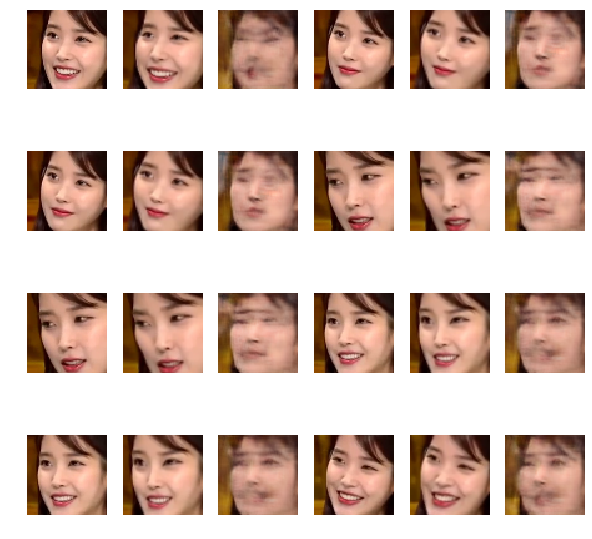

In [50]:
warp_pre = generator_output.predict(warp_data_output)
plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(4,6,1+(i*6))
    plt.imshow(data_output[i])
    plt.axis("off")
    plt.subplot(4,6,2+(i*6))
    plt.imshow(warp_data_output[i])
    plt.axis("off")
    plt.subplot(4,6,3+(i*6))
    plt.imshow(warp_pre[i])
    plt.axis("off")    
    plt.subplot(4,6,4+(i*6))
    plt.imshow(data_output[i+1])
    plt.axis("off")
    plt.subplot(4,6,5+(i*6))
    plt.imshow(warp_data_output[i+1])
    plt.axis("off")
    plt.subplot(4,6,6+(i*6))
    plt.imshow(warp_pre[i+1])
    plt.axis("off")